In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
k=10 # number of arms
num_problems = 2000 
q_star = np.random.normal(0, 1, (num_problems,k))
arms=[0]*k
for i in range(10):
    arms[i] = np.random.normal(q_star[0,i], 1,2000)

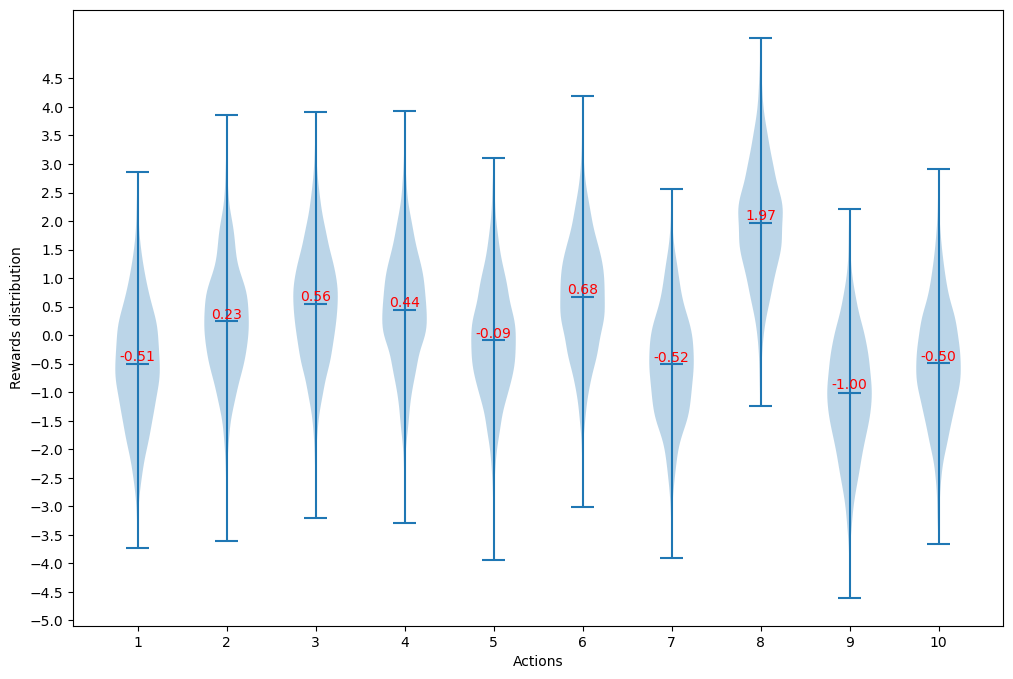

In [11]:
plt.figure(figsize=(12,8))
plt.ylabel('Rewards distribution')
plt.xlabel('Actions')
plt.xticks(range(1,11))
plt.yticks(np.arange(-5,5,0.5))

plt.violinplot(arms, positions=range(1,11), showmeans=True)
medians=[np.median(arms[i]) for i in range(10)]

for i, median in enumerate(medians, start=1):
  plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', fontsize=10, color='red')


plt.show()

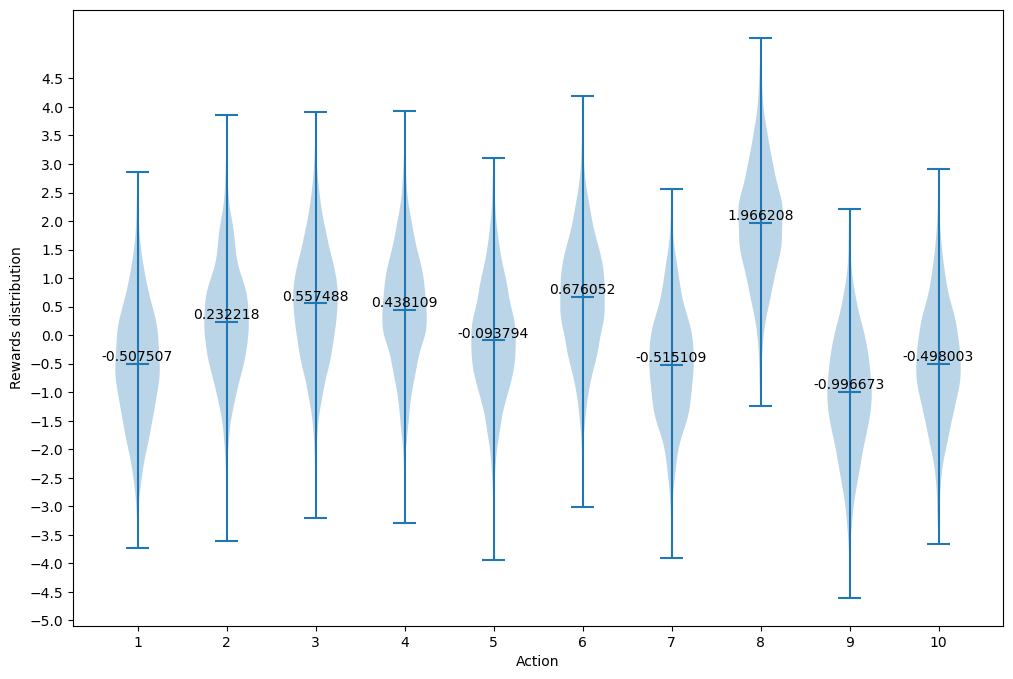

In [12]:
plt.figure(figsize=(12,8))
plt.ylabel('Rewards distribution')
plt.xlabel('Action')
plt.xticks(range(1,11))
plt.yticks(np.arange(-5,5,0.5))
plt.violinplot(arms, positions=range(1, 11), showmedians=True)
medians = [np.median(arms[i]) for i in range(10)]

for i, median in enumerate(medians, start=1):
    plt.text(i, median, f'{median:2f}', ha = 'center', va = 'bottom', fontsize=10, color = 'black')

plt.show()

In [13]:
#incremental implementation
def bandit(action, problem):
  return np.random.normal(q_star[problem,action],1)

In [14]:
def simple_max(Q, N, T):
    #return np.argmax(Q)
    return np.random.choice(np.flatnonzero(Q == Q.max())) # if same value persists then it breaks the ties by selecting any one randomly

#Q: A list/arrua pf esto,ated actopm va;ies (expected rewards for each arm)
#N: represents the number of times each arm has been selected
#t: represents the current timestep in the bandit problem

In [15]:
def simple_bandit(k, epsilon, steps, initial_Q, alpha=0, argmax_func=simple_max):
    rewards = np.zeros(steps) # cumulative rewards per step
    actions = np.zeros(steps) # count of optiomal actions selected per step

    for i in tqdm(range(num_problems)): #loop over problme instances
        Q = np.ones(k) * initial_Q # initialize Q
        N = np.zeros(k) # initialize number of rewards given
        best_action = np.argmax(q_star[i]) #optimal actioin for problem instance
        for t in range(steps):
            #Epsilon-greedy action selection
            if np.random.rand() < epsilon: # explore (random action)
                a = np.random.randint(k)
            else: # exploit
                a = argmax_func(Q, N, t) # Exploit (greedy action)
            #Get reward from bandit environment
            reward = bandit(a,i)
            #Update action count
            N[a] += 1
            #Update Q-value using incremental update or fixed step-size
            if alpha > 0:
                Q[a] = Q[a] + (reward - Q[a]) * alpha #fixed step-size update
            else:
                Q[a] = Q[a] + (reward - Q[a]) / N[a] # Sample-average update
            #Track rewards and optimal action selections
            rewards[t] += reward
            #compute averate rewards and optimal action selection percentage
            if a == best_action:
                actions[t] += 1

    return np.divide(rewards, num_problems), np.divide(actions, num_problems)

In [16]:
ep_0, ac_0 = simple_bandit(k = 10, epsilon = 0, steps = 1000, initial_Q = 0)
ep_01, ac_01 = simple_bandit(k = 10, epsilon = 0.01, steps = 1000, initial_Q = 0)
ep_1, ac_1 = simple_bandit(k = 10, epsilon = 0.1, steps = 1000, initial_Q = 0)

100%|██████████| 2000/2000 [01:03<00:00, 31.66it/s]


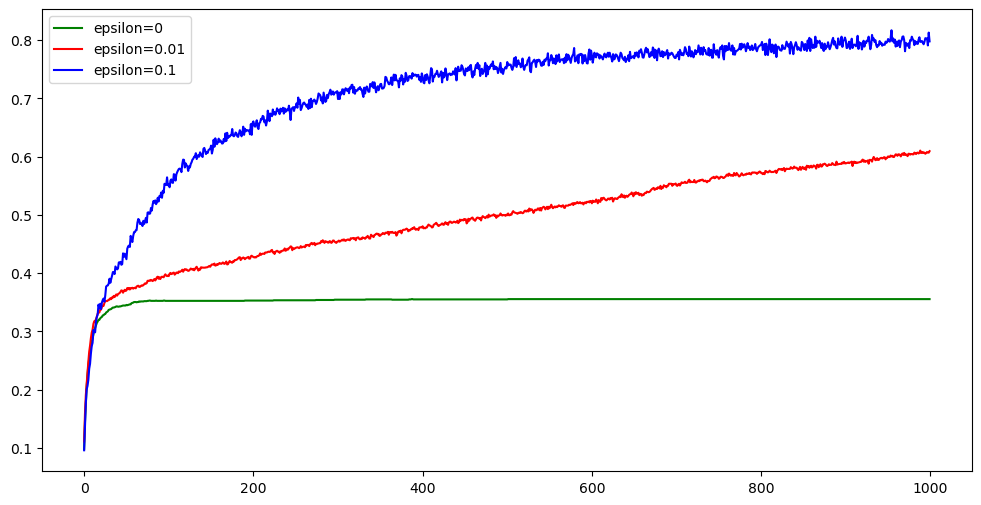

In [25]:
plt.figure(figsize=(12,6))
plt.plot(ac_0,'g', label='epsilon=0')
plt.plot(ac_01,'r', label='epsilon=0.01')
plt.plot(ac_1,'b', label='epsilon=0.1')
plt.legend()
plt.show()

In [ ]:
#ep_0, ep_01, ep_1 - Average Rewards per step ie This shows how the rewards change over the first step


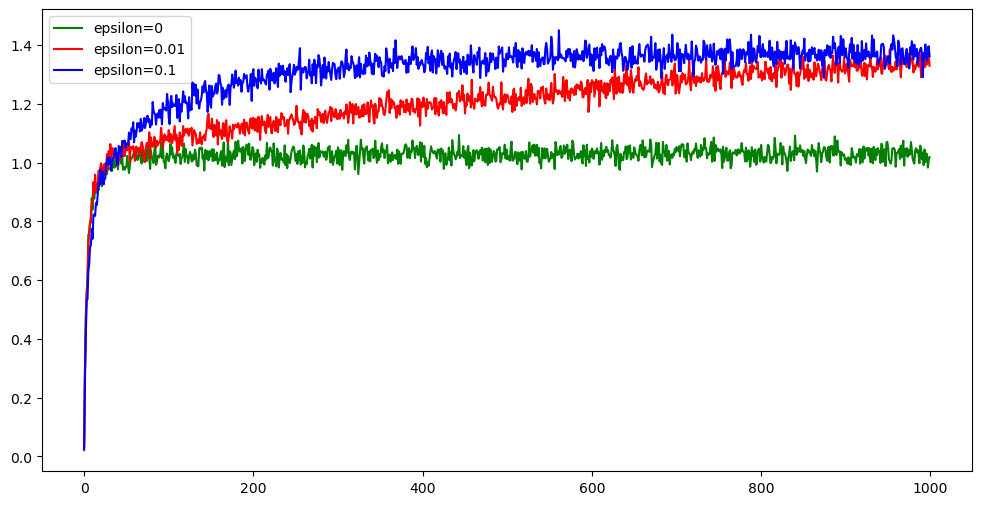

In [17]:
plt.figure(figsize=(12,6))
plt.plot(ep_0,'g', label='epsilon=0')
plt.plot(ep_01,'r', label='epsilon=0.01')
plt.plot(ep_1,'b', label='epsilon=0.1')
plt.legend()
plt.show()

Optimistic initial values

Plot compares the percentage of optimal action selection over time for two strategies:

ac_1(Red - 'Realistic') - E = 0.1, initial_Q = 0
ac_opt_0 (Blue - 'Optimistic') - E = 0, initial_Q = 5, alpha = 0.2

Optimistic initialization (init_Q = 5) accelerates learning. Exploration-based methods (e = 0.1) require more trails to learn the best action Both strategies may eventually reach a similar success rate

In [19]:
opt_0, ac_opt_0 = simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=5, alpha = 0.2)

100%|██████████| 2000/2000 [01:08<00:00, 29.11it/s]


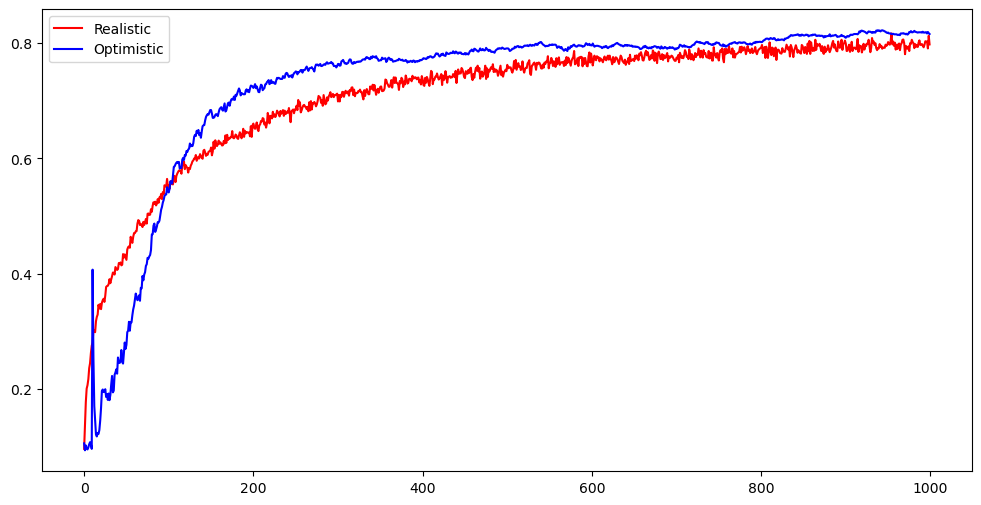

In [20]:
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0, 3, 0.2))
plt.plot(ac_1,'r', label='Realistic')
plt.plot(ac_opt_0,'b', label='Optimistic')
plt.legend()
plt.show()

Upper-Confidence-Bound

In [21]:
def ucb(Q, N, t): #function using UCB for action selection problem
    c = 2
    if N.min() == 0:
        return np.random.choice(np.flatnonzero(N == N.min()))

    M = Q + c * np.sqrt(np.divide(np.log(t), N))
    return np.argmax(M) # breaming ties randomly

In [22]:
ucb_2, ac_ucb_2 = simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=0, argmax_func=ucb)

100%|██████████| 2000/2000 [00:40<00:00, 48.98it/s]


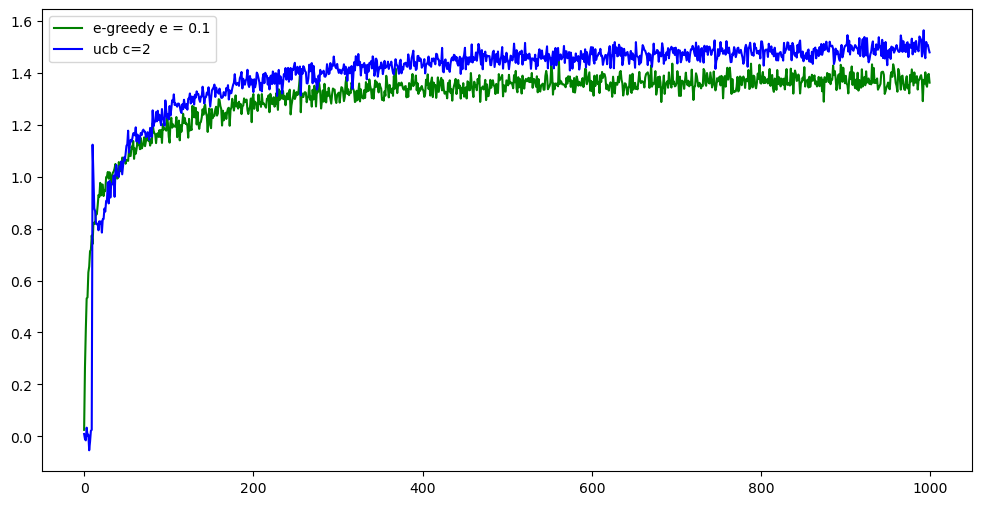

In [24]:
plt.figure(figsize=(12,6))
plt.plot(ep_1, 'g', label='e-greedy e = 0.1')
plt.plot(ucb_2, 'b', label='ucb c=2')
plt.legend()
plt.show()

Gradient Bandit Algorithms - this funtion implements the softmax action selection strtegy, which is commondly used in reinforcement learning and multi-armed bandits to make probabilistic action choices.

In [26]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    M = e_x / e_x.sum()
    return np.argmax(M), M

In [40]:
def gradient_bandit(k, steps, alpha, initial_Q, is_baseline=True):
    rewards = np.zeros(steps)
    actions = np.zeros(steps)

    for i in tqdm(range(num_problems)):
        Q = np.ones(k) * initial_Q #initial Q estimates action values (not used for seleciton bur for learning).
        N = np.zeros(k) # initialize number of rewards given
        R = np.zeros(k) # Rewards
        H = np.zeros(k) # initialize preferences keeps track of action preferecnes (higher means more likely to be chosen).
        pi = np.zeros(k) #stores the softmax probability distribution.
        best_action = np.argmax(q_star[i]) # best action of i'th problem

        for t in range(steps):
            a, pi = softmax(H)

            reward = bandit(a, i)
            N[a] += 1
            Q[a] = Q[a] + (reward - Q[a]) / N[a]

            for action_i in range(k):
                if action_i == a:
                    H[a] = H[a] + alpha * (reward - R[a]) * (1 - pi[a])
                else:
                    H[action_i] = H[action_i] - alpha* (reward-R[action_i]) * pi[action_i]

            if is_baseline == True:
                R[a] = Q[a]
            rewards[t] += reward
            if a == best_action:
                actions[t] += 1 

    return np.divide(rewards, num_problems), np.divide(actions, num_problems)

In [42]:
sft_4, ac_sft_4 = gradient_bandit(k = 10, steps = 1000, alpha = 0.4, initial_Q = 0, is_baseline = False)
sft_4_baseline, ac_sft_4_baseline = gradient_bandit(k=10, steps=1000, alpha=0.4, initial_Q = 0, is_baseline = True)

100%|██████████| 2000/2000 [01:04<00:00, 31.01it/s]


In [43]:
sft_1, ac_sft_1 = gradient_bandit(k = 10, steps = 1000, alpha = 0.1, initial_Q = 0, is_baseline = False)
sft_1_baseline, ac_sft_1_baseline = gradient_bandit(k=10, steps=1000, alpha=0.1, initial_Q = 0, is_baseline = True)

100%|██████████| 2000/2000 [01:03<00:00, 31.50it/s]


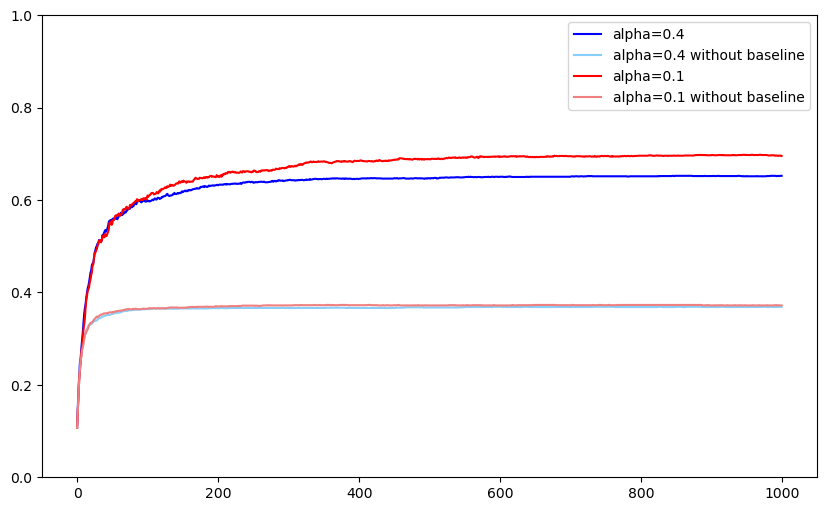

In [45]:
plt.figure(figsize=(10, 6))
plt.ylim([0,1])
plt.plot(ac_sft_4_baseline, 'b', label='alpha=0.4')
plt.plot(ac_sft_4, 'lightskyblue', label='alpha=0.4 without baseline')
plt.plot(ac_sft_1_baseline, 'r', label='alpha=0.1')
plt.plot(ac_sft_1, 'lightcoral', label='alpha=0.1 without baseline')
plt.legend()
plt.show()

In nonassociative tasks, there is no need to associate different actions with different situations. In these tasks the learner either tries to find a single best action when the task is stationary, or tries to track the best action as it changes over time when the task is nonstationary.

Associative search task involves both trial-and-error learning to serach for the best actions, and assoc